In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 16

In [3]:
file_name = 'wheat_12_var_avg_new'

In [4]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3

FILT = 2
FILTER = filter_method(FILT).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = 1

#will be used for test dataset in msc
reference= None

In [5]:
def dataset_file_name(file_name):
    name = "./dataset/"+str(file_name)
    if FILT != 0:
        name+="_FILTER_"+str(FILTER)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)+"_DERIVATIVE_"+str(DERIVATIVE)
    return name

In [6]:
DATASET_FILE_NAME = dataset_file_name(file_name)
X_train_file = DATASET_FILE_NAME+"_train_dataset.npy"
y_train_file = DATASET_FILE_NAME+"_train_dataset_label.npy"
X_test_file = DATASET_FILE_NAME+"_test_dataset.npy"
y_test_file = DATASET_FILE_NAME+"_test_dataset_label.npy"

In [7]:
X_train =  np.load(X_train_file)
y_train =  np.load(y_train_file)
X_test  =  np.load(X_test_file)
y_test  =  np.load(y_test_file)

In [8]:
y_set = set(y_train)

In [9]:
NUM_OF_CLASSES = len(y_set)

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_test.shape)

(19353, 147, 1)
(4839, 147, 1)


In [11]:
import keras
from keras import Sequential
from keras.layers import Input, Conv1D, Flatten, Dense, MaxPooling1D

In [12]:
def createModel(input_shape,num_classes):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=5 ))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    
    return model

In [13]:
model = createModel(X_train.shape[1:],NUM_OF_CLASSES)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 143, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 28, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense (Dense)               (None, 1000)              897000    
                                                                 
 dense_1 (Dense)             (None, 4)                 4004      
                                                                 
Total params: 901,196
Trainable params: 901,196
Non-trainable params: 0
__________________________________________________

In [15]:
train_eva = []
test_eva = []

In [16]:
history_dataframe = pd.DataFrame() 

In [17]:
for x in range(400):
    print("\nEpoch: ",x+1)
    history = model.fit(X_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    
    print("for training")
    train_eva.append(model.evaluate(X_train,y_train))
    print("for testing")
    test_eva.append(model.evaluate(X_test, y_test))


Epoch:  1
1210/1210 - 16s - loss: 1.3797 - accuracy: 0.2717 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 1.3160 - accuracy: 0.3551
for testing
152/152 [==============================] - 1s 4ms/step - loss: 1.3126 - accuracy: 0.3588

Epoch:  2
1210/1210 - 15s - loss: 1.2840 - accuracy: 0.3791 - 15s/epoch - 12ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 1.2654 - accuracy: 0.3748
for testing
152/152 [==============================] - 1s 4ms/step - loss: 1.2550 - accuracy: 0.3774

Epoch:  3
1210/1210 - 15s - loss: 1.2213 - accuracy: 0.4299 - 15s/epoch - 12ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 1.2110 - accuracy: 0.4143
for testing
152/152 [==============================] - 1s 4ms/step - loss: 1.1946 - accuracy: 0.4193

Epoch:  4
1210/1210 - 15s - loss: 1.1474 - accuracy: 0.4770 - 15s/epoch - 12ms/step
for training
605/605 [=============================

605/605 [==============================] - 2s 4ms/step - loss: 0.3971 - accuracy: 0.8508
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.4005 - accuracy: 0.8527

Epoch:  30
1210/1210 - 15s - loss: 0.3424 - accuracy: 0.8715 - 15s/epoch - 12ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.3230 - accuracy: 0.8811
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.3249 - accuracy: 0.8841

Epoch:  31
1210/1210 - 15s - loss: 0.3301 - accuracy: 0.8764 - 15s/epoch - 12ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.2977 - accuracy: 0.8978
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.3025 - accuracy: 0.8973

Epoch:  32
1210/1210 - 15s - loss: 0.3191 - accuracy: 0.8804 - 15s/epoch - 12ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.3112 - accuracy: 0.8874
for testing
152/152 [=======================

152/152 [==============================] - 1s 4ms/step - loss: 0.1617 - accuracy: 0.9446

Epoch:  58
1210/1210 - 15s - loss: 0.1636 - accuracy: 0.9426 - 15s/epoch - 12ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.1778 - accuracy: 0.9343
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.1858 - accuracy: 0.9304

Epoch:  59
1210/1210 - 15s - loss: 0.1591 - accuracy: 0.9448 - 15s/epoch - 13ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.1598 - accuracy: 0.9425
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.1626 - accuracy: 0.9426

Epoch:  60
1210/1210 - 15s - loss: 0.1596 - accuracy: 0.9445 - 15s/epoch - 13ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.1816 - accuracy: 0.9303
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.1891 - accuracy: 0.9289

Epoch:  61
1210/1210 - 15s - loss: 0.1526 -

1210/1210 - 15s - loss: 0.0987 - accuracy: 0.9658 - 15s/epoch - 12ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0924 - accuracy: 0.9681
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0975 - accuracy: 0.9653

Epoch:  87
1210/1210 - 15s - loss: 0.0986 - accuracy: 0.9662 - 15s/epoch - 12ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0795 - accuracy: 0.9745
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0873 - accuracy: 0.9688

Epoch:  88
1210/1210 - 15s - loss: 0.0957 - accuracy: 0.9669 - 15s/epoch - 12ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.1172 - accuracy: 0.9568
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.1306 - accuracy: 0.9508

Epoch:  89
1210/1210 - 15s - loss: 0.0967 - accuracy: 0.9658 - 15s/epoch - 12ms/step
for training
605/605 [==============================] - 2s 

605/605 [==============================] - 2s 4ms/step - loss: 0.0688 - accuracy: 0.9778
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0780 - accuracy: 0.9715

Epoch:  115
1210/1210 - 15s - loss: 0.0685 - accuracy: 0.9772 - 15s/epoch - 12ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0707 - accuracy: 0.9759
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0801 - accuracy: 0.9690

Epoch:  116
1210/1210 - 15s - loss: 0.0695 - accuracy: 0.9765 - 15s/epoch - 12ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0800 - accuracy: 0.9727
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0900 - accuracy: 0.9671

Epoch:  117
1210/1210 - 15s - loss: 0.0705 - accuracy: 0.9760 - 15s/epoch - 12ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0584 - accuracy: 0.9808
for testing
152/152 [====================

605/605 [==============================] - 2s 4ms/step - loss: 0.0489 - accuracy: 0.9846
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0591 - accuracy: 0.9793

Epoch:  143
1210/1210 - 15s - loss: 0.0564 - accuracy: 0.9806 - 15s/epoch - 13ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0666 - accuracy: 0.9756
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0782 - accuracy: 0.9707

Epoch:  144
1210/1210 - 15s - loss: 0.0547 - accuracy: 0.9819 - 15s/epoch - 13ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0561 - accuracy: 0.9812
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0632 - accuracy: 0.9804

Epoch:  145
1210/1210 - 15s - loss: 0.0556 - accuracy: 0.9809 - 15s/epoch - 13ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0403 - accuracy: 0.9875
for testing
152/152 [====================

605/605 [==============================] - 2s 4ms/step - loss: 0.0566 - accuracy: 0.9805
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0699 - accuracy: 0.9758

Epoch:  171
1210/1210 - 15s - loss: 0.0479 - accuracy: 0.9844 - 15s/epoch - 13ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0366 - accuracy: 0.9884
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0494 - accuracy: 0.9822

Epoch:  172
1210/1210 - 15s - loss: 0.0502 - accuracy: 0.9826 - 15s/epoch - 13ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0394 - accuracy: 0.9874
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0456 - accuracy: 0.9849

Epoch:  173
1210/1210 - 15s - loss: 0.0450 - accuracy: 0.9844 - 15s/epoch - 13ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0559 - accuracy: 0.9797
for testing
152/152 [====================

605/605 [==============================] - 2s 4ms/step - loss: 0.0361 - accuracy: 0.9877
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0446 - accuracy: 0.9847

Epoch:  199
1210/1210 - 15s - loss: 0.0375 - accuracy: 0.9875 - 15s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0399 - accuracy: 0.9857
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0548 - accuracy: 0.9806

Epoch:  200
1210/1210 - 15s - loss: 0.0415 - accuracy: 0.9860 - 15s/epoch - 13ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0425 - accuracy: 0.9855
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0583 - accuracy: 0.9816

Epoch:  201
1210/1210 - 16s - loss: 0.0372 - accuracy: 0.9868 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0394 - accuracy: 0.9877
for testing
152/152 [====================

605/605 [==============================] - 2s 4ms/step - loss: 0.0266 - accuracy: 0.9907
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0400 - accuracy: 0.9857

Epoch:  227
1210/1210 - 15s - loss: 0.0359 - accuracy: 0.9874 - 15s/epoch - 13ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0421 - accuracy: 0.9851
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0549 - accuracy: 0.9795

Epoch:  228
1210/1210 - 15s - loss: 0.0325 - accuracy: 0.9883 - 15s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0328 - accuracy: 0.9881
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0450 - accuracy: 0.9862

Epoch:  229
1210/1210 - 15s - loss: 0.0321 - accuracy: 0.9884 - 15s/epoch - 13ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0332 - accuracy: 0.9889
for testing
152/152 [====================

605/605 [==============================] - 3s 4ms/step - loss: 0.0304 - accuracy: 0.9899
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0479 - accuracy: 0.9841

Epoch:  255
1210/1210 - 16s - loss: 0.0298 - accuracy: 0.9893 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0188 - accuracy: 0.9943
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0304 - accuracy: 0.9893

Epoch:  256
1210/1210 - 16s - loss: 0.0292 - accuracy: 0.9899 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0290 - accuracy: 0.9897
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0435 - accuracy: 0.9855

Epoch:  257
1210/1210 - 16s - loss: 0.0303 - accuracy: 0.9894 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0238 - accuracy: 0.9917
for testing
152/152 [====================

605/605 [==============================] - 3s 4ms/step - loss: 0.0158 - accuracy: 0.9953
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0298 - accuracy: 0.9893

Epoch:  283
1210/1210 - 16s - loss: 0.0245 - accuracy: 0.9911 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0188 - accuracy: 0.9944
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0315 - accuracy: 0.9899

Epoch:  284
1210/1210 - 16s - loss: 0.0252 - accuracy: 0.9912 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0373 - accuracy: 0.9865
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0588 - accuracy: 0.9793

Epoch:  285
1210/1210 - 16s - loss: 0.0265 - accuracy: 0.9900 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0186 - accuracy: 0.9938
for testing
152/152 [====================

605/605 [==============================] - 3s 4ms/step - loss: 0.0477 - accuracy: 0.9821
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0659 - accuracy: 0.9771

Epoch:  311
1210/1210 - 17s - loss: 0.0224 - accuracy: 0.9926 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0220 - accuracy: 0.9926
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0410 - accuracy: 0.9864

Epoch:  312
1210/1210 - 16s - loss: 0.0236 - accuracy: 0.9922 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0259 - accuracy: 0.9903
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0442 - accuracy: 0.9862

Epoch:  313
1210/1210 - 16s - loss: 0.0260 - accuracy: 0.9909 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0335 - accuracy: 0.9885
for testing
152/152 [====================

605/605 [==============================] - 3s 4ms/step - loss: 0.0311 - accuracy: 0.9895
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0439 - accuracy: 0.9857

Epoch:  339
1210/1210 - 16s - loss: 0.0230 - accuracy: 0.9924 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0207 - accuracy: 0.9925
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0442 - accuracy: 0.9847

Epoch:  340
1210/1210 - 16s - loss: 0.0188 - accuracy: 0.9933 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0116 - accuracy: 0.9965
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0281 - accuracy: 0.9917

Epoch:  341
1210/1210 - 16s - loss: 0.0231 - accuracy: 0.9924 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0115 - accuracy: 0.9968
for testing
152/152 [====================

605/605 [==============================] - 3s 4ms/step - loss: 0.0718 - accuracy: 0.9728
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0951 - accuracy: 0.9663

Epoch:  367
1210/1210 - 16s - loss: 0.0181 - accuracy: 0.9936 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0128 - accuracy: 0.9960
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0271 - accuracy: 0.9907

Epoch:  368
1210/1210 - 16s - loss: 0.0191 - accuracy: 0.9938 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0340 - accuracy: 0.9870
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0529 - accuracy: 0.9810

Epoch:  369
1210/1210 - 16s - loss: 0.0210 - accuracy: 0.9923 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0148 - accuracy: 0.9950
for testing
152/152 [====================

605/605 [==============================] - 3s 5ms/step - loss: 0.0127 - accuracy: 0.9952
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0269 - accuracy: 0.9928

Epoch:  395
1210/1210 - 16s - loss: 0.0206 - accuracy: 0.9928 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0120 - accuracy: 0.9961
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0269 - accuracy: 0.9905

Epoch:  396
1210/1210 - 16s - loss: 0.0166 - accuracy: 0.9939 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0178 - accuracy: 0.9937
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0396 - accuracy: 0.9882

Epoch:  397
1210/1210 - 16s - loss: 0.0156 - accuracy: 0.9944 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0132 - accuracy: 0.9956
for testing
152/152 [====================

In [18]:
history_dataframe

,loss,accuracy
0,1.379729,0.271689
1,1.283959,0.379114
2,1.221273,0.429908
3,1.147411,0.477032
4,1.027834,0.538469
...,...,...
395,0.016645,0.993851
396,0.015609,0.994368
397,0.015637,0.994678
398,0.017529,0.993851


In [19]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','accuracy'])

In [20]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

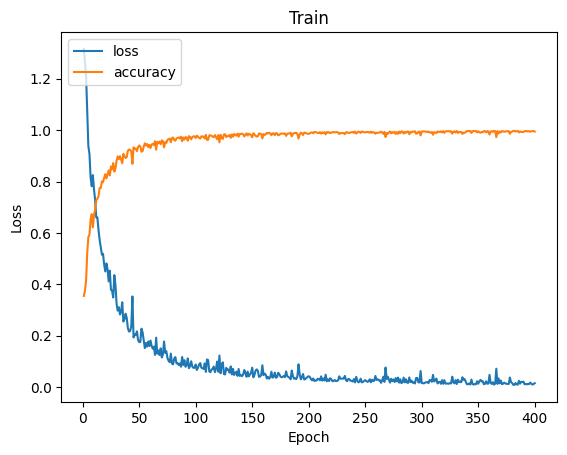

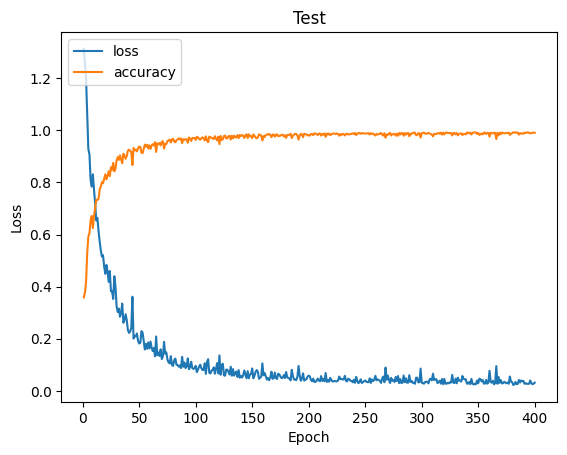

In [21]:
plot_graph(train_eva_df,'Train','Epoch','Loss',['loss','accuracy'])
plot_graph(test_eva_df,'Test','Epoch','Loss',['loss','accuracy'])

In [22]:
train_eva_df['accuracy'].max()

0.9973647594451904

In [23]:
train_eva_df.idxmax()

loss          0
accuracy    381
dtype: int64

In [24]:
test_eva_df['accuracy'].max()

0.9927670955657959

In [25]:
test_eva_df.idxmax()

loss          0
accuracy    393
dtype: int64

In [26]:
for x in range(400,600):
    print("\nEpoch: ",x+1)
    history = model.fit(X_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    
    print("for training")
    train_eva.append(model.evaluate(X_train,y_train))
    print("for testing")
    test_eva.append(model.evaluate(X_test, y_test))


Epoch:  401
1210/1210 - 18s - loss: 0.0146 - accuracy: 0.9950 - 18s/epoch - 15ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0191 - accuracy: 0.9925
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0383 - accuracy: 0.9874

Epoch:  402
1210/1210 - 16s - loss: 0.0164 - accuracy: 0.9944 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0113 - accuracy: 0.9960
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0285 - accuracy: 0.9911

Epoch:  403
1210/1210 - 17s - loss: 0.0167 - accuracy: 0.9941 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0081 - accuracy: 0.9976
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0253 - accuracy: 0.9924

Epoch:  404
1210/1210 - 17s - loss: 0.0181 - accuracy: 0.9937 - 17s/epoch - 14ms/step
for training
605/605 [=====================

for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0106 - accuracy: 0.9962
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0291 - accuracy: 0.9905

Epoch:  430
1210/1210 - 16s - loss: 0.0139 - accuracy: 0.9953 - 16s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0209 - accuracy: 0.9926
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0432 - accuracy: 0.9866

Epoch:  431
1210/1210 - 16s - loss: 0.0145 - accuracy: 0.9950 - 16s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0165 - accuracy: 0.9942
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0345 - accuracy: 0.9890

Epoch:  432
1210/1210 - 17s - loss: 0.0135 - accuracy: 0.9950 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0096 - accuracy: 0.9972
for testing
152/152 [=======

605/605 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.9979
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0268 - accuracy: 0.9911

Epoch:  458
1210/1210 - 17s - loss: 0.0128 - accuracy: 0.9958 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0195 - accuracy: 0.9928
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0364 - accuracy: 0.9880

Epoch:  459
1210/1210 - 18s - loss: 0.0121 - accuracy: 0.9961 - 18s/epoch - 15ms/step
for training
605/605 [==============================] - 4s 6ms/step - loss: 0.0064 - accuracy: 0.9981
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.0226 - accuracy: 0.9921

Epoch:  460
1210/1210 - 17s - loss: 0.0137 - accuracy: 0.9948 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0073 - accuracy: 0.9973
for testing
152/152 [====================

605/605 [==============================] - 3s 5ms/step - loss: 0.0189 - accuracy: 0.9931
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0439 - accuracy: 0.9878

Epoch:  486
1210/1210 - 17s - loss: 0.0123 - accuracy: 0.9961 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.9976
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0237 - accuracy: 0.9913

Epoch:  487
1210/1210 - 17s - loss: 0.0135 - accuracy: 0.9955 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0093 - accuracy: 0.9966
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0289 - accuracy: 0.9911

Epoch:  488
1210/1210 - 18s - loss: 0.0123 - accuracy: 0.9956 - 18s/epoch - 15ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0054 - accuracy: 0.9985
for testing
152/152 [====================

605/605 [==============================] - 3s 5ms/step - loss: 0.0086 - accuracy: 0.9973
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0246 - accuracy: 0.9917

Epoch:  514
1210/1210 - 17s - loss: 0.0146 - accuracy: 0.9951 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0144 - accuracy: 0.9949
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0301 - accuracy: 0.9903

Epoch:  515
1210/1210 - 17s - loss: 0.0111 - accuracy: 0.9959 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0544 - accuracy: 0.9771
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0892 - accuracy: 0.9702

Epoch:  516
1210/1210 - 17s - loss: 0.0104 - accuracy: 0.9963 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.9980
for testing
152/152 [====================

605/605 [==============================] - 3s 5ms/step - loss: 0.0080 - accuracy: 0.9972
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0307 - accuracy: 0.9901

Epoch:  542
1210/1210 - 18s - loss: 0.0158 - accuracy: 0.9949 - 18s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0049 - accuracy: 0.9988
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0219 - accuracy: 0.9936

Epoch:  543
1210/1210 - 18s - loss: 0.0081 - accuracy: 0.9973 - 18s/epoch - 15ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0208 - accuracy: 0.9917
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0478 - accuracy: 0.9845

Epoch:  544
1210/1210 - 18s - loss: 0.0107 - accuracy: 0.9962 - 18s/epoch - 15ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0348 - accuracy: 0.9869
for testing
152/152 [====================

605/605 [==============================] - 3s 5ms/step - loss: 0.0079 - accuracy: 0.9977
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0280 - accuracy: 0.9905

Epoch:  570
1210/1210 - 18s - loss: 0.0094 - accuracy: 0.9966 - 18s/epoch - 15ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0087 - accuracy: 0.9968
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0334 - accuracy: 0.9895

Epoch:  571
1210/1210 - 18s - loss: 0.0103 - accuracy: 0.9958 - 18s/epoch - 15ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0123 - accuracy: 0.9955
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0314 - accuracy: 0.9907

Epoch:  572
1210/1210 - 18s - loss: 0.0096 - accuracy: 0.9967 - 18s/epoch - 15ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0075 - accuracy: 0.9971
for testing
152/152 [====================

605/605 [==============================] - 3s 5ms/step - loss: 0.0055 - accuracy: 0.9983
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0266 - accuracy: 0.9934

Epoch:  598
1210/1210 - 18s - loss: 0.0078 - accuracy: 0.9976 - 18s/epoch - 15ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0203 - accuracy: 0.9917
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0393 - accuracy: 0.9886

Epoch:  599
1210/1210 - 18s - loss: 0.0077 - accuracy: 0.9976 - 18s/epoch - 15ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0076 - accuracy: 0.9977
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0283 - accuracy: 0.9911

Epoch:  600
1210/1210 - 17s - loss: 0.0132 - accuracy: 0.9952 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0081 - accuracy: 0.9971
for testing
152/152 [====================

In [28]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','accuracy'])

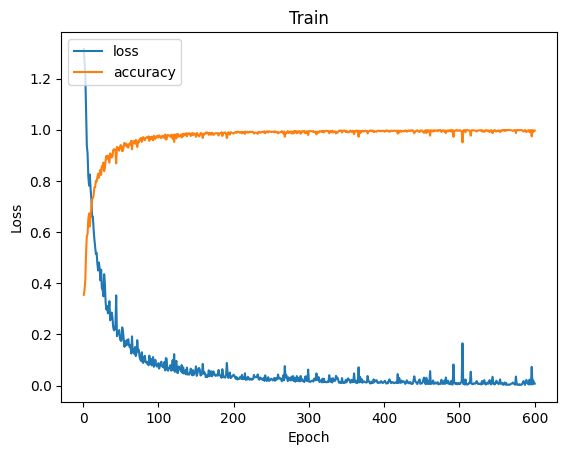

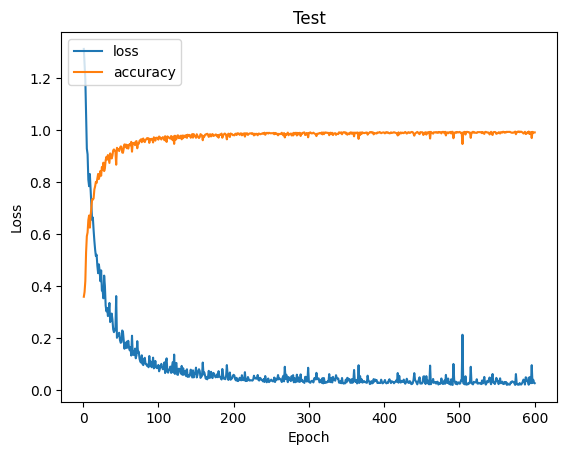

In [29]:
plot_graph(train_eva_df,'Train','Epoch','Loss',['loss','accuracy'])
plot_graph(test_eva_df,'Test','Epoch','Loss',['loss','accuracy'])

In [30]:
train_eva_df['accuracy'].max()

0.9993799328804016

In [31]:
train_eva_df.idxmax()

loss          0
accuracy    557
dtype: int64

In [32]:
test_eva_df['accuracy'].max()

0.9950402975082397

In [33]:
test_eva_df.idxmax()

loss          0
accuracy    578
dtype: int64